# Lab 5
#### Author: Duan Yiyong
#### Date: 2022.5.27

In [3]:
import numpy as np
import random
import time
import os
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
# Make sure the Dataloader.py is in the same directory as this notebook
from data_loader import DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.ensemble import RandomForestRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras
from tensorflow.keras import regularizers
from functools import partial

#### Description
The CIFAR-10 dataset contains of 60,000 32x32 colour images in 10 classes, with 6,000 images per class, 50,000 training images and 10,000 test images. The main task of this project is implementing MLP model and CNN model to classify test images, and compare the performance of the two models.

# 1. Data Preparation and Visualization

## 1.1 Import Data from DataLoader

In [4]:
# Import 5 data_batches into training set, test_batch into test set.
image_width, image_height, image_Nchannels = 32, 32, 3
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
X, y = DataLoader.load_batch('data_batch') # X contains the bytes information of image, y contains the label (0-9)
X_test, y_test = DataLoader.load_batch('test_batch', Nbatches=1)

## 1.2. A quick inspection of the outputs from the `load_batch` function

In [3]:
print('X_test.shape =', X_test.shape, 'data type:', X_test.dtype)
print('y_test.shape =', y_test.shape, 'data type:', y_test.dtype)

X_test.shape = (10000, 32, 32, 3) data type: float32
y_test.shape = (10000,) data type: uint8


## 1.3 85/15 Validation set

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.15, random_state = 43)

In [5]:
print("Training set contains: ", len(X_train), "instances.")
print("Validation set contains: ", len(X_valid), "instances.")
print("Test set contains: ", len(X_test), "instances.")

Training set contains:  42500 instances.
Validation set contains:  7500 instances.
Test set contains:  10000 instances.


## 1.4 Visualization

In [ ]:
# Define a function to display 5x5 images
def display_random_image(data_set,label_set,times):
    n = len(data_set)
    rows = 5
    columns = 5
    fig = plt.figure(figsize=(10,10))
    fig.tight_layout(pad=0.4,w_pad=0.4,h_pad=2) 
    for i in range(1,times+1):
        index = random.randint(0,n-1)
        ax = fig.add_subplot(rows,columns,i, xticks=[], yticks=[])
        ax.imshow(np.squeeze(data_set[index]))
        label_index = label_set[index]
        class_name = class_names[label_index]
        plt.title(class_name,fontsize=20)

### 1.4.1 Display 20 images randomly choosing from Training set

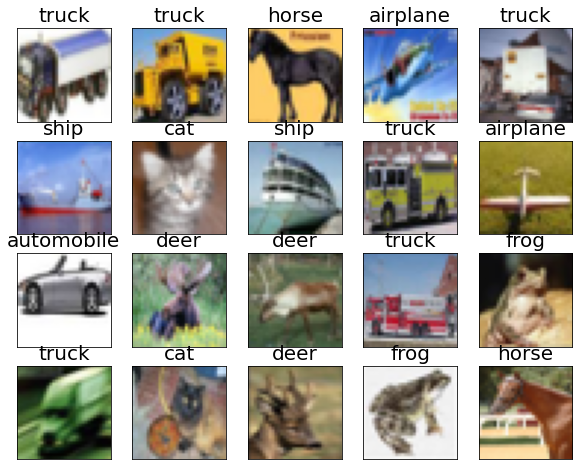

In [ ]:
# Training set
display_random_image(X_train,y_train,20)

### 1.4.2 Display 20 images randomly choosing from Validation set

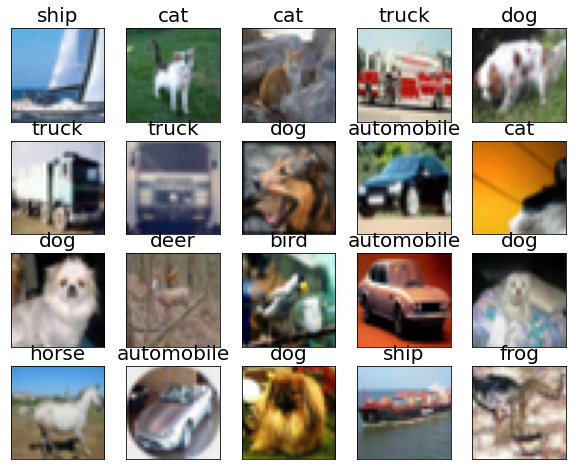

In [ ]:
# Validation set
display_random_image(X_valid,y_valid,20)

### 1.4.3 Display 20 images randomly choosing from Test set

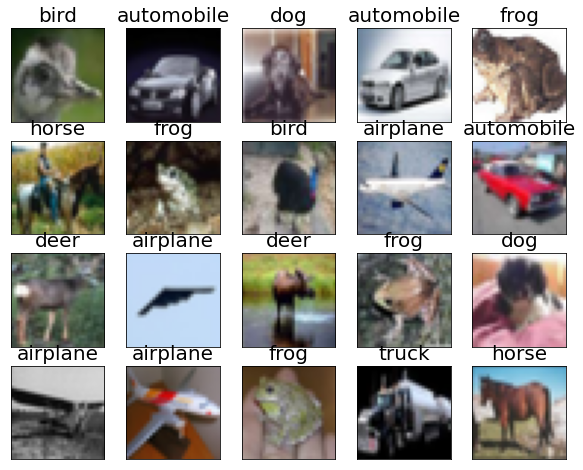

In [ ]:
# test set
display_random_image(X_test,y_test,20)

# 2 MLP Implementation
Task:
1. Create MLP architecture with designing hidden layers (2 to 3 and an output layer)
2. Hyperparameters tunning with grid search: *Learning rate* and *Dropout rate*
3. Evaluation with *F1-score* and *accuracy*
4. Load and Train model

## 2.1 Design MLP Architecture

In [12]:
# Create model funciton with Initial Parameters setting
def MLP_model_fn(dropout_rate=0.2, learning_rate=1e-3, kernel_initializer = "ones"):
    # Use regularization to prevent overfitting
    RegularizedDense = partial(keras.layers.Dense,
                                kernel_initializer = kernel_initializer,
                                kernel_regularizer = regularizers.L2(0.01),
                                activity_regularizer = regularizers.L2(0.01))
    # model definition
    model = keras.models.Sequential([
        # Flatten
        keras.layers.Flatten(input_shape=[32,32,3]),
        # BatchNormalization layer for optimal scale
        keras.layers.BatchNormalization(),
        # Dropout
        keras.layers.Dropout(rate=dropout_rate),
        
        # The first hidden layer
        # Set the RegularizedDense units the same as the shape of image
        RegularizedDense(1024, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(rate=dropout_rate),

        # The second hidden layer
        # Set the half units as the first dense
        RegularizedDense(512, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(rate=dropout_rate),
        
        # The output layer
        # Set the units as 10, and activation as softmax
        RegularizedDense(10, activation="softmax"),
    ])
    # Set Stochastic Gradient Descent as optimizer
    optimizer=keras.optimizers.SGD(learning_rate=learning_rate, nesterov=True)
    # Compile the model
    model.compile(loss="sparse_categorical_crossentropy", optimizer = optimizer, metrics=["accuracy"])
    return model

#### Inspecting the model before optimal parameters tuning

In [ ]:
# The summary of MLP architecture
MLP_model_summary = MLP_model_fn(dropout_rate=0.2, learning_rate=0.01).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 batch_normalization (BatchN  (None, 3072)             12288     
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 1024)              3146752   
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0

## 2.2 Hyperparameters setting

In [21]:
# Grid search parameters setting
# learning rate scheduling and Dropout rate
dropout_rate = [0.3,0.2]
learning_rate = [1e-3,1e-4]
kernel_initializer = ["ones", "he_normal"]

# Passing dictionaries to parameters to the GridSearchCV
param_grid = dict(dropout_rate=dropout_rate, learning_rate=learning_rate, kernel_initializer = kernel_initializer)

# Define the classifier by Keras
MLP_model_clf = KerasClassifier(build_fn=MLP_model_fn, verbose=0)

# Early stopping step when a monitored metric has stopped improving.
MLP_EarlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=10,
    verbose=5,
    mode="auto", # it will stop when the quantity monitored has stopped increasing
    min_delta= 0.001 # minimum change for val_accuracy is 0.001
)

# Learning Rate Scheduler setting
# This function keeps learning rate in the first 10 epochs, and decrease lr exponentially after that.
def scheduler(epoch, lr):
   if epoch < 10:
     return lr
   else:
     return lr * tf.math.exp(-0.1)
MLP_Lr_Scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.2, verbose=8, patience = 5, min_lr = 0.01) # factor by the learning rate will be reduced 0.2, lower bound = 0.01

/environment/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  # This is added back by InteractiveShellApp.init_path()


## 2.3 MLP x GridSearch Cross Validation

In [15]:
grid = GridSearchCV(estimator = MLP_model_clf, param_grid=param_grid, cv =3, verbose = 10)
grid_result = grid.fit(X_train, y_train, validation_data = (X_valid, y_valid), callbacks=[MLP_Lr_Scheduler,MLP_EarlyStopping])

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3; 1/8] START dropout_rate=0.3, kernel_initializer=ones, learning_rate=0.001
[CV 1/3; 1/8] END dropout_rate=0.3, kernel_initializer=ones, learning_rate=0.001;, score=0.097 total time=  10.4s
[CV 2/3; 1/8] START dropout_rate=0.3, kernel_initializer=ones, learning_rate=0.001
[CV 2/3; 1/8] END dropout_rate=0.3, kernel_initializer=ones, learning_rate=0.001;, score=0.100 total time=   9.9s
[CV 3/3; 1/8] START dropout_rate=0.3, kernel_initializer=ones, learning_rate=0.001
[CV 3/3; 1/8] END dropout_rate=0.3, kernel_initializer=ones, learning_rate=0.001;, score=0.096 total time=  13.8s
[CV 1/3; 2/8] START dropout_rate=0.3, kernel_initializer=ones, learning_rate=0.0001
[CV 1/3; 2/8] END dropout_rate=0.3, kernel_initializer=ones, learning_rate=0.0001;, score=0.097 total time=  10.2s
[CV 2/3; 2/8] START dropout_rate=0.3, kernel_initializer=ones, learning_rate=0.0001
[CV 2/3; 2/8] END dropout_rate=0.3, kernel_initializer=ones, learn

#### Best accuracy and parameters

In [16]:
# Show the results and best model with mean accuracy and parameters
print("Best accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best accuracy: 0.317059 using {'dropout_rate': 0.2, 'kernel_initializer': 'he_normal', 'learning_rate': 0.001}


## 2.4 Load and Train model

In [22]:
# If model is in the path, load the each of the trained models and train it for one more epoch
if os.path.isfile('Duan_Yiyong-MLP.h5'):
    # Load the model
    MLP_model = keras.models.load_model("Duan_Yiyong-MLP.h5")
    # Display architecture 
    MLP_model.summary()
    # Train one more epoch
    MLP_model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs =1)
# If model hasn't been created in the path, create the model and save it in the path
else:
    MLP_start = time.time() # Start time point
    # Set up the model with the optimal parameters
    MLP_model = MLP_model_fn(dropout_rate=0.2, learning_rate=0.001, kernel_initializer = "he_normal")
    # Checkpoint to save progress
    MLP_Checkpoint = keras.callbacks.ModelCheckpoint("Duan_Yiyong-MLP.h5",save_best_only=True)
    # Display architecture
    MLP_model.summary()
    # Train the model for 100 epochs
    history = MLP_model.fit(X_train, y_train, validation_data = (X_valid, y_valid), callbacks=[MLP_Lr_Scheduler,MLP_EarlyStopping,MLP_Checkpoint], epochs=100)
    MLP_end = time.time()
    # Show the results and best model with mean accuracy and parameters
    print("Best accuracy: %f, time consuming: %f "% (max(history.history['accuracy']), MLP_end - MLP_start))

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_30 (Flatten)        (None, 3072)              0         
                                                                 
 batch_normalization_90 (Bat  (None, 3072)             12288     
 chNormalization)                                                
                                                                 
 dropout_90 (Dropout)        (None, 3072)              0         
                                                                 
 dense_90 (Dense)            (None, 1024)              3146752   
                                                                 
 batch_normalization_91 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dropout_91 (Dropout)        (None, 1024)            

## 2.5 Evaluation
The metrics we use to evaluate the model are *Accuracy* and *F1-score*. Besides, for visualization, confusion matrix is applied to display the result of classification.
For F1-score, *micro* is ofter used when imbalanced classes occur, while *macro* is applied for balanced multiclassification.

### 2.5.1 Display Accuracy and F1-score

In [13]:
MLP_model = keras.models.load_model("Duan_Yiyong-MLP.h5")
# Save prediction results on test score using optimal model
y_pred = np.argmax(MLP_model.predict(X_test), axis=1)

# load the best accuracy model
MLP_model.load_weights('Duan_Yiyong-MLP.h5') 
_, train_acc  = MLP_model.evaluate(X_train, y_train, verbose=0)

# accuracy, f1_score on test set
_, test_acc = MLP_model.evaluate(X_test, y_test, verbose=0)
accuracy = accuracy_score(y_test, y_pred)

# f1-score uses macro for balance multiclassification
f1 = f1_score(y_test, y_pred,average='macro')
print('Train_acc: %.5f, Test_acc: %.4f, f1-score: %.5f, Accuracy: %.4f' % 
        (train_acc, test_acc, f1, accuracy))

313/313 [==============================] - 1s 4ms/step
Train_acc: 0.81965, Test_acc: 0.5439, f1-score: 0.54351, Accuracy: 0.5439


In [ ]:
The test accuracy and f1-score are approximately 54% for MLP model.

### 2.5.2 Visualization with Confusion Matrix

#### Define Confusion Matrix function

In [24]:
# Function of confusion matrix
# Cited from scikit-learn. https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

#### Plot confusion matrix

Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix of MLP'}, xlabel='Predicted label', ylabel='True label'>

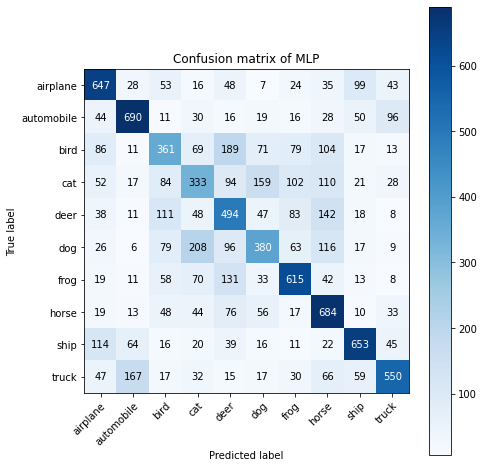

In [26]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                title='Confusion matrix of MLP')

### 2.5.3 Display predicted sampled images from test set

#### Display a few correctly classified images

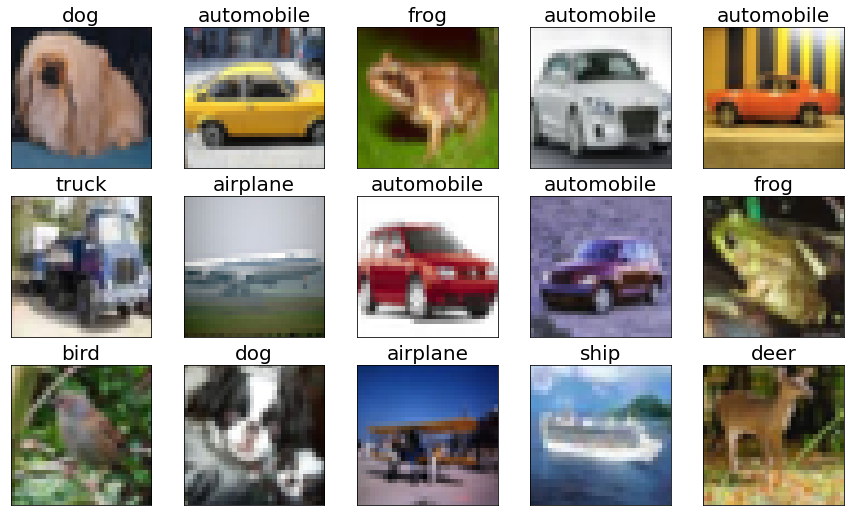

In [27]:
# Display a few correctly classified images
correct_index = []
for i in range(len(y_pred)):
    if y_pred[i] == y_test[i]:
        correct_index.append(i)
n = len(correct_index)
rows = 5
columns = 5
fig = plt.figure(figsize=(15,15))
fig.tight_layout(pad=0.5, w_pad=0.5, h_pad=2) 
for i in range(1,16):
    index = random.randint(0,n-1)
    index = correct_index[index]
    ax = fig.add_subplot(rows,columns,i, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    label_index = y_pred[index]
    class_name = class_names[label_index]
    plt.title(class_name,fontsize=20)

#### Display a few misclassified images

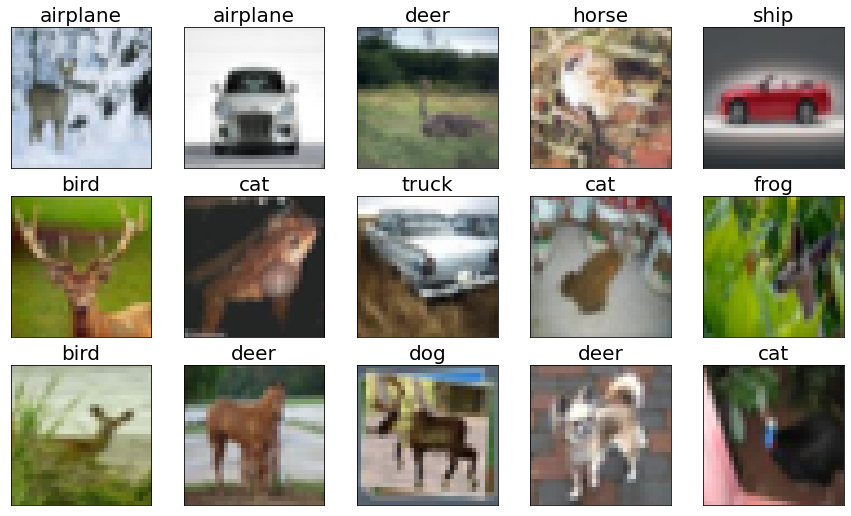

In [17]:
# Display a few misclassified images
incorrect_index_mlp = []
for i in range(len(y_pred)):
    if y_pred[i] != y_test[i]:
        incorrect_index_mlp.append(i)
n = len(incorrect_index_mlp)
rows = 5
columns = 5
fig = plt.figure(figsize=(15,15))
fig.tight_layout(pad=0.5, w_pad=0.5, h_pad=2) 
for i in range(1,16):
    index = random.randint(0,n-1)
    index = incorrect_index_mlp[index]
    ax = fig.add_subplot(rows,columns,i, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    label_index = y_pred[index]
    class_name = class_names[label_index]
    plt.title(class_name,fontsize=20)

# 3 CNN Implemantation


## 3.1 Design CNN Architecture function

Architecture outline:
- Input layer with Filter
- 1st and 2nd connected layer:
-- *BatchNormalization* layers
-- *Pooling* layers of size=2 between consecutive convolutional layers
-- 2 to 3 *Convolutional* layers
Follow by a ReLU layer
- 3rd convolutional layers:
-- Two connected hidden layers (Use the optimal parameters in architecture MLP)
-- Output layer

Optimizer and compile model

In [7]:
def CNN_model_fn(kernel_size=7, filter_number=128, activation='relu'): 
    # filter_number corresponds to number of kernels
    
    DefaultConv2D = partial(keras.layers.Conv2D,
                    kernel_size= kernel_size, activation=activation, padding="SAME")
    
    # Re-define regularization from optimal MLP architecture to prevent overfitting
    RegularizedDense = partial(keras.layers.Dense,
                                kernel_initializer = "he_normal",
                                kernel_regularizer = regularizers.L2(0.01),
                                activity_regularizer = regularizers.L2(0.01))
    # model architecture
    model = keras.models.Sequential([
                                    # First convolutional layer
                                    DefaultConv2D(filters=filter_number, kernel_size=kernel_size, strides=1,
                                                        padding="SAME", activation = activation, input_shape=X_train.shape[1:]), # [32,32,3]
        
                                    # Follow by a ReLU Layer, before pooling layer
                                    keras.layers.LeakyReLU(), 
                                    # Pooling layer to divide each spatial dimension by a factor of two, limit the risk of overfitting
                                    keras.layers.MaxPool2D(pool_size=2),
                                    # Repeat Convolutional layers twice, follow by one max pooling layer
                                    keras.layers.Dropout(0.3), # 30% drop rate for Convolutional Layers as MLP
                                    keras.layers.BatchNormalization(),
        
                                    # Second Convolutional layer
                                    DefaultConv2D(filters=2*filter_number),
                                    keras.layers.LeakyReLU(), 
                                    keras.layers.MaxPool2D(pool_size=2),
                                    keras.layers.Dropout(0.3), 
                                    keras.layers.BatchNormalization(),
                                     
                                    # Third Convolutional layer
                                    DefaultConv2D(filters=4*filter_number),
                                    keras.layers.LeakyReLU(), 
                                    keras.layers.MaxPool2D(pool_size=2),
                                    keras.layers.Dropout(0.3), 
                                    keras.layers.BatchNormalization(),
                                    
                                    # 2 Fully Connected layers
                                    keras.layers.LeakyReLU(),  
                                    keras.layers.MaxPool2D(pool_size=2),
                                    keras.layers.Flatten(),
                                    # First hidden layers
                                    RegularizedDense(units=1024, activation='relu'),
                                    keras.layers.Dropout(0.2), 
                                    keras.layers.BatchNormalization(),
                                    # Second hidden layer
                                    RegularizedDense(units=512, activation='relu'),
                                    keras.layers.Dropout(0.2), # 20% drop rate for Output Layers
                                    keras.layers.BatchNormalization(),
                                    # Dense output layer
                                    RegularizedDense(units=10, activation='softmax'),
                                        ])
    # Set Stochastic Gradient Descent as optimizer
    # Refer to MLP, Learning rate = 0.001
    optimizer=keras.optimizers.SGD(learning_rate=0.001, nesterov=True)
    # Compile the model
    model.compile(loss="sparse_categorical_crossentropy", optimizer = optimizer, metrics=["accuracy"])
    return model

#### Inspecting the model before optimal parameters tuning

In [29]:
CNN_model_fn().summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       18944     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 dropout_93 (Dropout)        (None, 16, 16, 128)       0         
                                                                 
 batch_normalization_93 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)     

## 3.2 CNN x GridSearch Cross Validation
Choose two possible settings for kernel_size, filter_number and activation.

In [30]:
from keras.wrappers.scikit_learn import KerasClassifier
# Grid search parameters setting
# learning rate scheduling and Dropout rate
kernel_size = [3,7]
filter_number = [64, 128] # choose 64 and 128 to save time resource
activation = ["relu", "tanh"]

# Passing dictionaries to parameters to the GridSearchCV
param_grid_cnn = dict(kernel_size=kernel_size, filter_number=filter_number, activation = activation)

# Define the classifier by Keras
CNN_model_clf = KerasClassifier(build_fn=CNN_model_fn, verbose=0)

# Early stopping step when a monitored metric (val_accuracy) has stopped improving.
CNN_EarlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=10,
    verbose=5,
    mode="auto", # it will stop when the quantity monitored has stopped decreasing
    min_delta = 0.0001 # Minimum change in the monitored quantity to qualify as an improvement
)

# Here we use ReduceLROnPlateau from keras callbacks
# Reduce learning rate when a metric has stopped improving.
CNN_Lr_Scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.2, verbose=0, patience = 5, min_lr = 0.01) # factor by the learning rate will be reduced, lower bound = 0.01

/environment/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  if sys.path[0] == '':


#### Grid Search Training

In [7]:
# We have 8 parameters here, GridSearch CV is enough, if we have more, RandomizedSearchCV will be preferable 
grid_cnn = GridSearchCV(estimator = CNN_model_clf, param_grid=param_grid_cnn, cv =3, verbose = 10)
grid_result_cnn = grid_cnn.fit(X_train, y_train, validation_data = (X_valid, y_valid), callbacks=[CNN_Lr_Scheduler,CNN_EarlyStopping])
# Show the results and best model with mean accuracy and parameters
print("Best accuracy: %f using %s" % (grid_result_cnn.best_score_, grid_result_cnn.best_params_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3; 1/8] START activation=relu, filter_number=64, kernel_size=3............
[CV 1/3; 1/8] END activation=relu, filter_number=64, kernel_size=3;, score=0.116 total time= 1.4min
[CV 2/3; 1/8] START activation=relu, filter_number=64, kernel_size=3............
[CV 2/3; 1/8] END activation=relu, filter_number=64, kernel_size=3;, score=0.120 total time= 1.5min
[CV 3/3; 1/8] START activation=relu, filter_number=64, kernel_size=3............
[CV 3/3; 1/8] END activation=relu, filter_number=64, kernel_size=3;, score=0.123 total time= 1.5min
[CV 1/3; 2/8] START activation=relu, filter_number=64, kernel_size=7............
[CV 1/3; 2/8] END activation=relu, filter_number=64, kernel_size=7;, score=0.158 total time= 4.8min
[CV 2/3; 2/8] START activation=relu, filter_number=64, kernel_size=7............
[CV 2/3; 2/8] END activation=relu, filter_number=64, kernel_size=7;, score=0.146 total time= 4.2min
[CV 3/3; 2/8] START activation=relu

## 3.3 Load and Train model

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        9472      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_98 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 batch_normalization_98 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)     

2022-05-27 04:56:01.583359: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


1329/1329 [==============================] - 20s 12ms/step - loss: 34.3094 - accuracy: 0.1677 - val_loss: 33.3946 - val_accuracy: 0.2112 - lr: 0.0010
Epoch 2/100
1329/1329 [==============================] - 15s 11ms/step - loss: 30.7831 - accuracy: 0.2228 - val_loss: 29.9748 - val_accuracy: 0.2960 - lr: 0.0010
Epoch 3/100
1329/1329 [==============================] - 15s 11ms/step - loss: 29.0877 - accuracy: 0.2605 - val_loss: 30.0022 - val_accuracy: 0.2547 - lr: 0.0010
Epoch 4/100
1329/1329 [==============================] - 14s 11ms/step - loss: 27.5550 - accuracy: 0.2846 - val_loss: 28.1867 - val_accuracy: 0.2555 - lr: 0.0010
Epoch 5/100
1329/1329 [==============================] - 14s 11ms/step - loss: 26.1311 - accuracy: 0.3174 - val_loss: 25.5739 - val_accuracy: 0.3315 - lr: 0.0010
Epoch 6/100
1329/1329 [==============================] - 16s 12ms/step - loss: 24.8265 - accuracy: 0.3371 - val_loss: 24.3425 - val_accuracy: 0.3483 - lr: 0.0010
Epoch 7/100
1329/1329 [=================

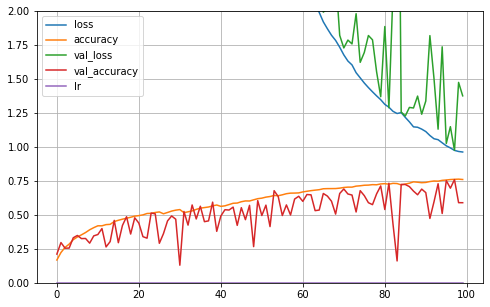

In [31]:
# If model is in the path, load the each of the trained models and train it for one more epoch
if os.path.isfile('Duan_Yiyong-CNN.h5'):
    # Load the model
    CNN_model = keras.models.load_model("Duan_Yiyong-CNN.h5")
    # Display architecture 
    CNN_model.summary()
    # Train one more epoch
    CNN_model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs =1)
# If model hasn't been created in the path, create the model and save it in the path
else:
    # Start time
    CNN_start =time.time()
    # Set up the model with the optimal parameters as grid search result
    CNN_model = CNN_model_fn(kernel_size=7, filter_number=64, activation = "relu") # fn = 64 for saving time, 128 may be better
    # Checkpoint to save progress
    CNN_Checkpoint = keras.callbacks.ModelCheckpoint("Duan_Yiyong-CNN.h5",save_best_only=True)
    # Display architecture
    CNN_model.summary()
    # Train the model for 100 epochs
    CNN_history = CNN_model.fit(X_train, y_train, validation_data = (X_valid, y_valid), callbacks=[CNN_Lr_Scheduler, CNN_EarlyStopping, CNN_Checkpoint], epochs=100)
    # End time
    CNN_end =time.time()
    # Show the results and best model with mean accuracy and parameters
    print("Best accuracy: %f, time consuming: %f "% (max(CNN_history.history['accuracy']),CNN_end - CNN_start))

    # Plot the history curve
    pd.DataFrame(CNN_history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2)
    plt.show()

Until the epoch stops at 100th times, the accuracy didn't stop increasing. Although 76% accuracy looks good, it may be improved by adjusting learning rate schedule.

## 3.4 Evaluation

### 3.4.1 Display Accuracy and F1-score

In [8]:
# Save prediction results on test score using optimal model
y_pred_cnn = np.argmax(CNN_model.predict(X_test), axis=1)

# load the best accuracy model
CNN_model.load_weights('Duan_Yiyong-CNN.h5') 
_, train_acc  = CNN_model.evaluate(X_train, y_train, verbose=0)

# accuracy, f1_score on test set
_, test_acc = CNN_model.evaluate(X_test, y_test, verbose=0)
accuracy = accuracy_score(y_test, y_pred_cnn)

# f1-score uses macro for balance multiclassification
f1 = f1_score(y_test, y_pred_cnn, average='macro')
print('Train_acc: %.5f, Test_acc: %.4f, f1-score: %.5f, Accuracy: %.4f' % 
        (train_acc, test_acc, f1, accuracy))

313/313 [==============================] - 16s 50ms/step
Train_acc: 0.85424, Test_acc: 0.7705, f1-score: 0.76919, Accuracy: 0.7705


### 3.4.2 Confusion Matrix

Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

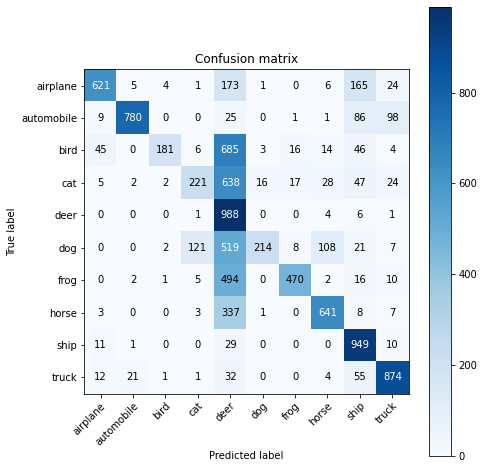

In [34]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_cnn, classes=class_names,
                title='Confusion matrix')

### 3.4.3 Display sampled images

#### Display a few correctly classified images

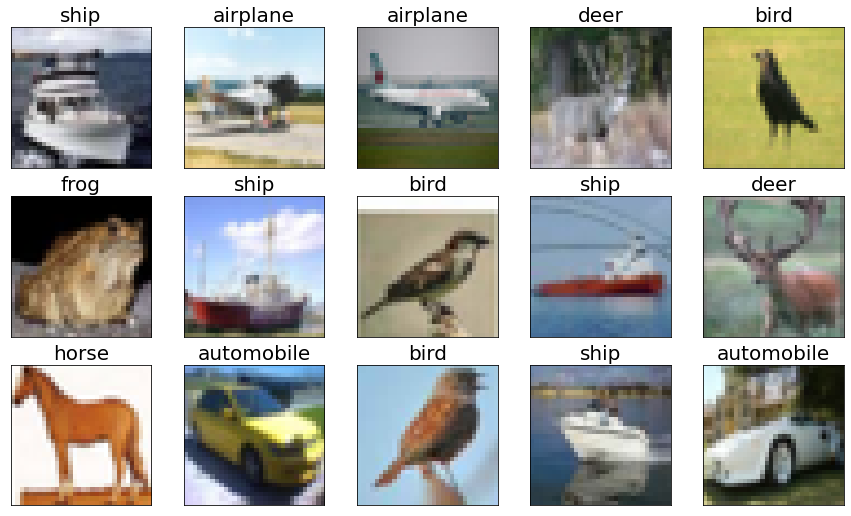

In [35]:
# Display a few correctly classified images
correct_index = []
for i in range(len(y_pred_cnn)):
    if y_pred_cnn[i] == y_test[i]:
        correct_index.append(i)
n = len(correct_index)
rows = 5
columns = 5
fig = plt.figure(figsize=(15,15))
fig.tight_layout(pad=0.5, w_pad=0.5, h_pad=2) 
for i in range(1,16):
    index = random.randint(0,n-1)
    index = correct_index[index]
    ax = fig.add_subplot(rows,columns,i, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    label_index = y_pred_cnn[index]
    class_name = class_names[label_index]
    plt.title(class_name,fontsize=20)

In [ ]:
From the sampled correclt classified results, the accuracy looks pretty good.

#### Display failure cases

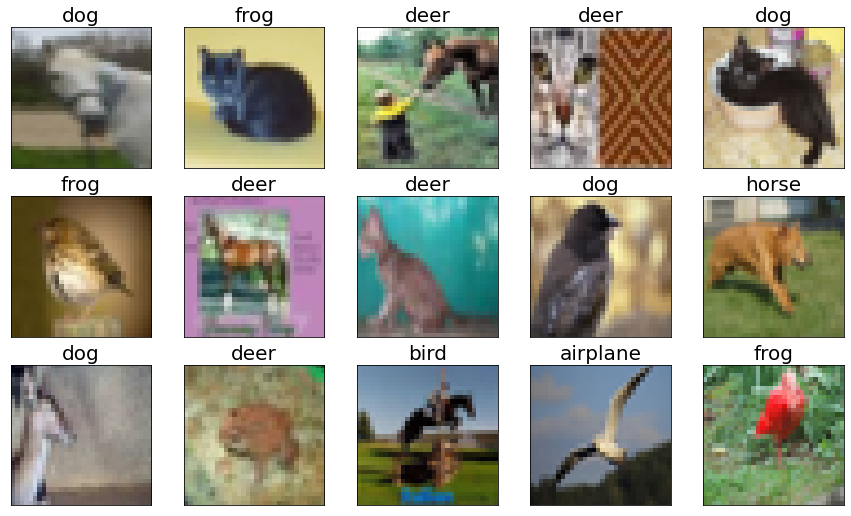

In [11]:
# Display a few misclassified images
incorrect_index = []
for i in range(len(y_pred_cnn)):
    if y_pred_cnn[i] != y_test[i]:
        incorrect_index.append(i)
n = len(incorrect_index)
rows = 5
columns = 5
fig = plt.figure(figsize=(15,15))
fig.tight_layout(pad=0.5, w_pad=0.5, h_pad=2) 
for i in range(1,16):
    index = random.randint(0,n-1)
    index = incorrect_index[index]
    ax = fig.add_subplot(rows,columns,i, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    label_index = y_pred_cnn[index]
    class_name = class_names[label_index]
    plt.title(class_name,fontsize=20)

However, from the sampled correclt classified results, we can see the improvement room for the model

# 4. Comparison between MLP and CNN

## 4.1 Classification performance

#### Accuracy and F1-score

Accuracy represents all the correctly identified cases, but includes the True Negative cases, which the model predicted True but it actually isn't.

- For MLP model, the Test_accuracy is 0.5439. 
- For CNN model, the Test_accuracy is 0.7705.

While F1-score is the harmonic mean of Precision and Recall, providing a better measure of correctly classified cases.

- For MLP model, f1-score is 0.53747.
- For CNN model, f1-score is 0.76919.

From the comparison, we can see that with several convolutional layers added in, the performance gets better.

## 4.2 Model Complexity and Computation time

**MLP:** two hidden layers and one output layer, with RegularizedDense and BatchNormalization. 
- Parameters using {'dropout_rate': 0.2, 'kernel_initializer': 'he_normal', 'learning_rate': 0.001}.
- Total params: 3,695,114
- Trainable params: 3,685,898
- Non-trainable params: 9,216
- Computational time: 955.4s

**CNN:** three convolutional layers and two connected layer as MLP, with ReLU layer, RegularizedDense and BatchNormalization.
- Parameters using {'activation': 'tanh', 'filter_number': 128, 'kernel_size': 7}
-Total params: 3,604,362
-Trainable params: 3,600,394
-Non-trainable params: 3,968
-Computational time: 1534.5s

From the comparison, we can see the complexities of two models are similar, except for Non-trainable parameters, where CNN model has less. However, CNN has more layers than MLP, which cost more time resources.

## 4.3 Classification performance on Confusion Matrix

In [ ]:
**MLP:** From the Confusion Matrix plot in 2.5.2, with mean accuracy of 54%, the model classifies badly on deer, dog, cat and bird (around 40%).

**CNN:** From the Confusion Matrix plot in 3.4.2, the model misclassifies extremely at dog, cat, frog and horse, but correctly classifies deer most.

It's interesting to see the misclassification difference on animals between MLP and CNN, where CNN amplify the discrepancy between misclassified labels and the others, due to its architecture.

#### Overall, CNN model cost more 600s for 20% accuracy improvement, which is better than MLP model. However, CNN model may have worse performance on classes with similar characteristic (misclassify cats on deer with 63.8% rate), where MLP will work generally better on this.